# Arrival time picking

Script to determine arrival picks of events.
Script is based on cross correlations of channels with a good SNR, and interpolation in between those channels.
The picks are iteratively improved by taking a smart time window around the picks and repeating the process.

In [1]:
from readers import das_reader as reader
from readers import t_to_f, utc_to_f
import glob, os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from processing import trim, detrend, taper

from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d

from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.core import UTCDateTime

from block_filters import block_bandpass

## Parameters

In [2]:
# specific event to look at
ev = 14
# lenth of noise window (s)
noise_window_len = 2
# extra data to read in before event (s)
extra_data_prior = 1
# extra data to read in after event (s)
extra_data_post = 1
# amplitude above which to clean data
clean_amplitude = 2000
# average frequency threshold above which to clean data
clean_threshold = 1e4
# fraction to taper for standard processing
taper_fraction = 0.05
# lower frequency bandpass filter
freq_min = 2
# higher frequency bandpass filter
freq_max = 20
# first SNR threshold with channels to include in picking
snr_threshold1 = 1.5
# second SNR threshold
snr_threshold2 = 1.1
# exclude picks with this many channels in between them (fraction of channels)
interpolate_jump_fraction = 0.3
# exclude picks with this many channels in between them (number of channels)
interpolate_jump_minimum = 50
# exclude channels with jumps this close to edge (fraction of channels)
jump_edge = 0.1
# interpolate factor in cross correlation function
interpolate_factor = 10
# minimum velocity to determine allowed shift between channels
minimum_velocity = 600
# threshold at which to stop 2d correlation (fraction)
shift_threshold_fraction1 = 0.5
# threshold at which to stop 2d correlation (fraction)
shift_threshold_fraction2 = 0.7
# minimum number of good picks to continue
minimum_non_nan_picks = 8
# number of iterations to improve picks
iterations = 3
# center window around picks (1/window_fraction before picks, rest after)
window_fraction = 2
# smooth the window
window_smoothing = 50
# decrease window size per iteration (factor)
decrease_window_product = 3
# decrease window size per iteration (number)
decrease_window_sum = 3
# minimum number of good channels to continue
good_channels = 5

## Functions

In [3]:
def clean_data(data, clean_amplitude, clean_threshold):
    """
    function to clean data. 
    If data is above a certain amplitude, and it's spectrum is above a certain average, 
    then remove trace and replace by average of neighbouring traces.
    """
    tmax = np.zeros(len(data))
    # determine max amplitude per channel
    for i in range(len(data)):
        tmax[i] = np.max(np.abs(data[i]))

    idx = np.where(tmax > clean_amplitude)[0]
    id_del = []

    nt = data.shape[1]
    dt = 1.0/float(fs)
    freq = np.linspace(-0.5/dt,0.5/dt,nt)

    idx1=int(np.where(np.min(np.abs(freq-1.0))==np.abs(freq-1.0))[0][0])
    idx2=int(np.where(np.min(np.abs(freq-10.0))==np.abs(freq-10.0))[0][0])
    
    # determine average spectrum of channels with amplitudes above threshold
    for c, i in enumerate(idx):
        df = np.abs(np.fft.fft(data[i]))
        df=np.roll(df,int((data.shape[1]-1)/2))

        if np.mean(df[idx1:idx2]) < clean_threshold:
            id_del.append(c)

    if len(id_del) > 0:
        idx = np.delete(idx, np.array(id_del))
    
    # replace traces with high amplitudes in time/frequency domain with average of neighbours
    for c, i in enumerate(idx):
        id1 = 1
        id2 = 1

        while i - idx[c-id1] == id1:
            id1 += 1

        while c+id2 < len(idx) and idx[c+id2] - i == id2:
            id2 += 1

        if i == 0:
            data[i] = data[i+id2].copy()
        elif i+id2 == len(data):
            data[i] = data[i-id1].copy()
        else:
            data[i] = (data[i-id1] + data[i+id2])/2
          
    return data

def power(x):
    y = np.sum(x**2)/len(x)
    return y


def snr_channels(snr, threshold):
    """
    function to determine channels with good SNR and jumps in between the channels.
    """
    idx_snr0 = np.where(snr > threshold)[0]
    
    gr = np.gradient(idx_snr0)
    nt = len(gr)
    for k in range(10): gr[1:nt-1]=(gr[1:nt-1]+gr[0:nt-2]+gr[2:nt])/3.0
    idx_snr1 = idx_snr0[np.where(gr < 8)[0]]
    
    if len(idx_snr1) > 1:
        idx_snr = idx_snr1.copy()
    else:
        idx_snr = idx_snr0.copy()
        
    jump0 = np.zeros(len(idx_snr)-1)
    for i in range(len(idx_snr)-1):
        jump0[i] = idx_snr[i+1] - idx_snr[i]
   
    return idx_snr, jump0


def correlate_channels(signal, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z, no_nan=None, uncertainty=True):
    """ 
    function to correlate channels with good SNR.
    Calculates distance in between channels to determine maximum correlation shift.
    Takes FWHM as uncertainty for the pick
    """
    pick = np.zeros(len(signal))
    pick0 = np.zeros(len(idx_snr))
    s0 = np.zeros(len(idx_snr))

    id_good = []


    for i in range(len(idx_snr)-1):
        if type(no_nan) == np.ndarray:
            if no_nan[idx_snr[i]] == False:
                      continue
        if int(idx_snr[i] + startchannel[ev] < channel[0]):
            continue

        # calculate distance
        if len(id_good) == 0:
            channel_idx1 = int(idx_snr[i] + startchannel[ev] - channel[0])
            channel_idx2 = int(idx_snr[i+1] + startchannel[ev] - channel[0])
        else:
            channel_idx1 = int(idx_snr[id_good][-1] + startchannel[ev] - channel[0])
            channel_idx2 = int(idx_snr[i] + startchannel[ev] - channel[0])

        distance = np.sqrt( (x[channel_idx2]-x[channel_idx1])**2 + (y[channel_idx2]-y[channel_idx1])**2 + (z[channel_idx2]-z[channel_idx1])**2  )
        allowed_shift = distance / minimum_velocity * fs
        
        if distance > 300:
            allowed_shift *= 0.2
            
        allowed_shift +=10
        allowed_shift = int(allowed_shift)

        if len(id_good) == 0:
            cc = correlate(signal[idx_snr][i], signal[idx_snr][i+1], allowed_shift)
        else:
            cc = correlate(signal[idx_snr][id_good][-1], signal[idx_snr][i], allowed_shift)    

        allowed_shift -= 10

        if allowed_shift < 3:
            allowed_shift = 3

        c0 = np.arange(0,len(cc)) - int(len(cc)/2)
        f = interpolate.interp1d(c0, cc, kind='cubic')
        c1 = np.arange(0, len(cc)-1, 1/interpolate_factor) - int(len(cc)/2)
        cc_interp = f(c1)

        mid_idx = int(len(cc_interp)/2)

        id0 = int(mid_idx - allowed_shift * interpolate_factor )
        id1 = int(mid_idx + allowed_shift * interpolate_factor )
        if id0 < 0:
            id0 = 0
        if id1 > len(cc_interp)-1:
            id1 = len(cc_interp)-1
        shift0, value = xcorr_max(cc_interp[id0:id1], abs_max=False)

        if value < 0:
            continue

        id_good.append(i)

        shift = shift0 / interpolate_factor
        pick0[id_good[-1]] = shift.copy()
        if len(id_good) > 1:
            pick0[id_good[-1]] += pick0[id_good[-2]]

        ### calculate uncertainty pick

        id0 = shift0 + cc_interp.shape[0]/2

        for ii in range(len(cc_interp)):
            id2 = int(id0) + ii
            if id2 == len(cc_interp)-1:
                break
            if cc_interp[id2] < value/2:
                break
        for ii in range(len(cc_interp)):
            id1 = int(id0) - ii
            if id1 == 0:
                break
            if cc_interp[id1] < value/2:
                break           

        s0[id_good[-1]] = (id2-id1) / interpolate_factor / fs

    id_good = np.array(id_good)
    
    return pick0, s0, id_good


def interpolate_channels(pick0, s0, idx_snr, id_good, signal_len, jump0, interpolate_jump, jump_edge, interpolate_jump_minimum=interpolate_jump_minimum):
    """
    function to interpolate in between channels with good SNR
    interpolates the uncertainty too
    excludes picks when gap between good picks is too large, or too few traces near start
    """
    
    pick = np.zeros(signal_len)
    pick[idx_snr][id_good] = pick0[id_good].copy()

    if len(pick0) > 4:
        interpolate_method = 'cubic'
    else:
        interpolate_method = 'linear'
        
    x_interp = np.arange(signal_len)
    f = interpolate.interp1d(idx_snr[id_good], pick0[id_good], kind=interpolate_method)

    pick_interp = f(x_interp[idx_snr[id_good][0]:idx_snr[id_good][-1]])
    pick[idx_snr[id_good][0]:idx_snr[id_good][-1]] = pick_interp.copy()

    pick = 0-pick 
    pick[pick==0] = np.nan
    pick[~np.isnan(pick)] += np.abs(np.min(pick[~np.isnan(pick)]))
    
    s = np.zeros(signal_len)
    f_s = interpolate.interp1d(idx_snr[id_good], s0[id_good], kind='linear')
    
    s_interp = f_s(x_interp[idx_snr[id_good][0]:idx_snr[id_good][-1]])
    s[idx_snr[id_good][0]:idx_snr[id_good][-1]] = s_interp.copy()
    
    s[s==0] = np.nan
    
    j0 = np.where(jump0 > interpolate_jump*len(signal))[0]
    j1 = np.where(jump0 > interpolate_jump_minimum)[0]
    jump = np.concatenate((j0, j1))
    for j in jump:
        if j < jump_edge*signal_len:
            pick[:idx_snr[j+1]] = np.nan
            s[:idx_snr[j+1]] = np.nan

        elif jump[0] > signal_len - jump_edge*signal_len:
            pick[idx_snr[j-1]:] = np.nan
            s[idx_snr[j-1]:] = np.nan
            
        else:
            pick[idx_snr[j-1]:idx_snr[j+1]] = np.nan
            s[idx_snr[j-1]:idx_snr[j+1]] = np.nan
    
    return pick, s


def correlate_2d(signal, picks, shift_threshold_fraction):
    """
    shift picks over data to find where they fit
    take first fit above a certain threshold, to have a bias for earlier arrivals
    """
    pick_array_len = int( np.max(picks[~np.isnan(picks)]) - np.min(picks[~np.isnan(picks)])) + 1
    pick_array = np.zeros(( len(signal) , pick_array_len ))

    for i in range(len(signal)):
        if not np.isnan(picks[i]):
            pick_array[i, int(picks[i]- np.min(picks[~np.isnan(picks)]))] = 1
            
    cc = np.zeros( len(signal[0]) - pick_array_len)

    signal_norm = np.zeros(np.shape(signal))
    for i in range(len(signal)):
        norm = np.max(np.abs(signal[i]))
        if norm != 0:
            signal_norm[i] = signal[i]/ norm

    for i in range(len(signal[0]) - pick_array_len):
        ii = i + pick_array_len
        product = signal_norm[:,i:ii] * pick_array

        sum0 = np.sum(product)
        cc[i] = sum0
    #break

    shift = np.where(np.abs(cc) > shift_threshold_fraction*np.max(np.abs(cc)))[0][0]
    
    picks += shift
    
    if np.max(picks[~np.isnan(picks)]) > len(signal[0]):
        difference = np.max(picks[~np.isnan(picks)]) - len(signal[0])+1
        picks[~np.isnan(picks)] -= difference

    return picks


def fit_channels(signal, picks, s):
    """
    function to determine fit between picks and data
    """
    signal_norm = np.zeros(np.shape(signal))
    for i in range(len(signal)):
        norm = np.max(np.abs(signal[i]))
        if norm != 0:
            signal_norm[i] = signal[i]/ norm

    pick_array = np.zeros(np.shape(signal))

    for i in range(len(signal)):
        if not np.isnan(picks[i]):
            pick_array[i, int(picks[i]-1)] = 1/s[i]

    product = np.multiply(pick_array, signal_norm)
    shift_fit = np.sum(product) / len(signal)
    
    return np.abs(shift_fit)


def define_window(signal, picks, window_len, window_fraction, window_smoothing):
    """
    function to determine small time window around picks
    """
    start_window = np.zeros(len(signal))
    end_window = np.zeros(len(signal))
    
    no_nan = ~np.isnan(picks)
    
    for i in range(len(signal)):
        if no_nan[i]:
        
            idx = int(picks[i])

            if idx <= int(window_len/window_fraction):
                start = int(window_len/window_fraction) - idx
                start_window[i] = start

            elif len(signal[0]) - idx < window_len - int(window_len/window_fraction):
                start_window[i] = idx-int(window_len/window_fraction)

            else:
                start_window[i] = idx-int(window_len/window_fraction)
                
    start_window[no_nan] = gaussian_filter1d(start_window[no_nan], window_smoothing)
    end_window[no_nan] = start_window[no_nan] + window_len
    
    start_window[~no_nan] = np.nan
    end_window[~no_nan] = np.nan
    
    for i in range(len(signal)):
        if end_window[i] > len(signal[0]):
            end_window[i] = len(signal[0])
            
    return start_window, end_window


def plot(signal, t1, t2, fs, channel1, channel2, picks=None, start_window=None, end_window=None, save=False, shift_fit=None, ev=None, dpi=300):
    """
    plotting function
    """
    c = np.arange(channel1, channel2)
    outdir = os.path.abspath(r"/Users/saraklaasen/Documents/Work/Grimsvötn/figures/arrival time")
    fname = os.path.join(outdir, f'{ev}.jpg')
    
    fig = plt.figure(dpi=dpi)
    plt.imshow(signal, cmap='seismic', origin='lower', aspect='auto', extent=(0, t2-t1, int(channel1), int(channel2)))
    plt.xlabel('Time (s)')
    plt.ylabel('Channel')
    
    if np.all(picks) != None:
        plt.scatter(picks/fs, c, s=1, c=s, cmap='gray')
    if np.all(start_window) != None:
        plt.scatter(start_window/fs, c, s=1, c='green', alpha=0.1)
        plt.scatter(end_window/fs, c, s=1, c='green', alpha=0.1)
    if shift_fit != None:
        plt.title(str(shift_fit))
    if save:
        plt.savefig(fname, dpi=300)
    
    plt.show()

## open earthquake catalogue

In [4]:
flist = sorted(glob.glob("/Users/saraklaasen/Documents/Work/Grimsvötn/output/detectiondottir/catalogue.csv"))

df = pd.read_csv(flist[0], delimiter=';')

event = df['event'].values
starttime = df['start time'].values
endtime = df['end time'].values
startchannel = df['start channel'].values
endchannel = df['end channel'].values


## open position data

In [5]:
flist = sorted(glob.glob("/Users/saraklaasen/Documents/Work/Grimsvötn/grimsfjallcablegpx/hammer only/cubic/xyz.csv"))
df = pd.read_csv(flist[0], delimiter=',')
channel = df['channels'].values
x = df['x (km)'].values * 1000
y = df['y (km)'].values * 1000
z = df['z (km)'].values * 1000

## First iteration
### open default noise window

In [6]:
y1 = 2021
m1 = 5
d1 = 20
H1 = 1
M1 = 1
S1 = 10
y2 = y1
m2 = m1
d2 = d1
H2 = H1
M2 = M1
S2 = S1+2
flist, f1, f2 = t_to_f(m1, d1, H1, M1, S1, m2, d2, H2, M2, S2)

t1 = UTCDateTime(y1, m1, d1, H1, M1, S1)
t2 = UTCDateTime(y2, m2, d2, H2, M2, S2)


d, c, meta = reader(flist[f1:f2], channels=[int(channel[0]), int(channel[-1])], h5type='native', stream=False)
fs = int(meta['SamplingFrequency[Hz]'])
d = 116. * d / 8192. * fs / 10.
d = detrend(d)
d = taper(d, taper_fraction)
d = block_bandpass(d.T, freq_min, freq_max, fs)
d = d.T
d = trim(d, t1, t2, meta)

default_noise = clean_data(d, clean_amplitude, clean_threshold)

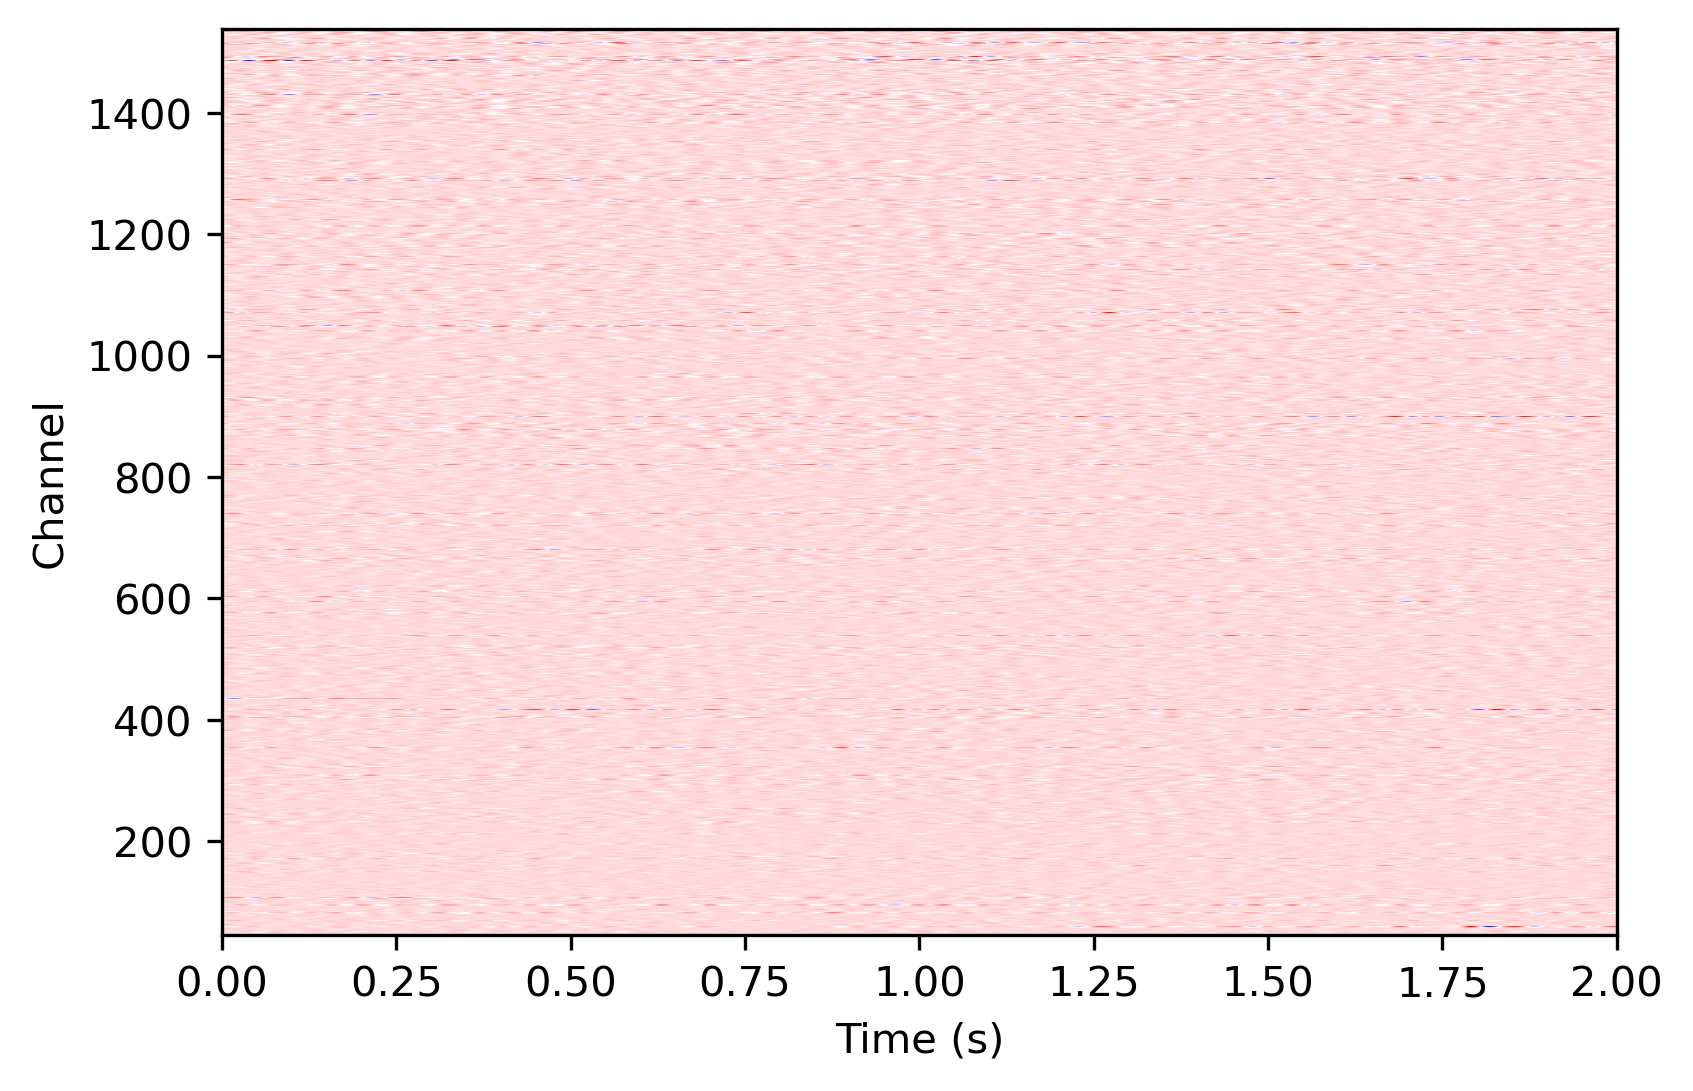

In [7]:
plot(default_noise, t1, t2, fs, channel[0], channel[-1])

### open data

In [8]:
y1, m1, d1, H1, M1, S1, y2, m2, d2, H2, M2, S2 = utc_to_f(UTCDateTime(starttime[ev])-extra_data_prior-noise_window_len, UTCDateTime(endtime[ev])+extra_data_post)
flist, f1, f2 = t_to_f(m1, d1, H1, M1, S1, m2, d2, H2, M2, S2)
if f1 == -1:
    f1 = 0
    
t1 = UTCDateTime(y1, m1, d1, H1, M1, S1)
t1 += noise_window_len
t2 = UTCDateTime(y2, m2, d2, H2, M2, S2)

d, c, meta = reader(flist[f1:f2], channels=[int(startchannel[ev]), int(endchannel[ev])], h5type='native', stream=False)
fs = int(meta['SamplingFrequency[Hz]'])
d = 116. * d / 8192. * fs / 10.
d = detrend(d)
d = taper(d, taper_fraction)
d = block_bandpass(d.T, freq_min, freq_max, fs)
d = d.T


data = trim(d, t1-noise_window_len, t2, meta)


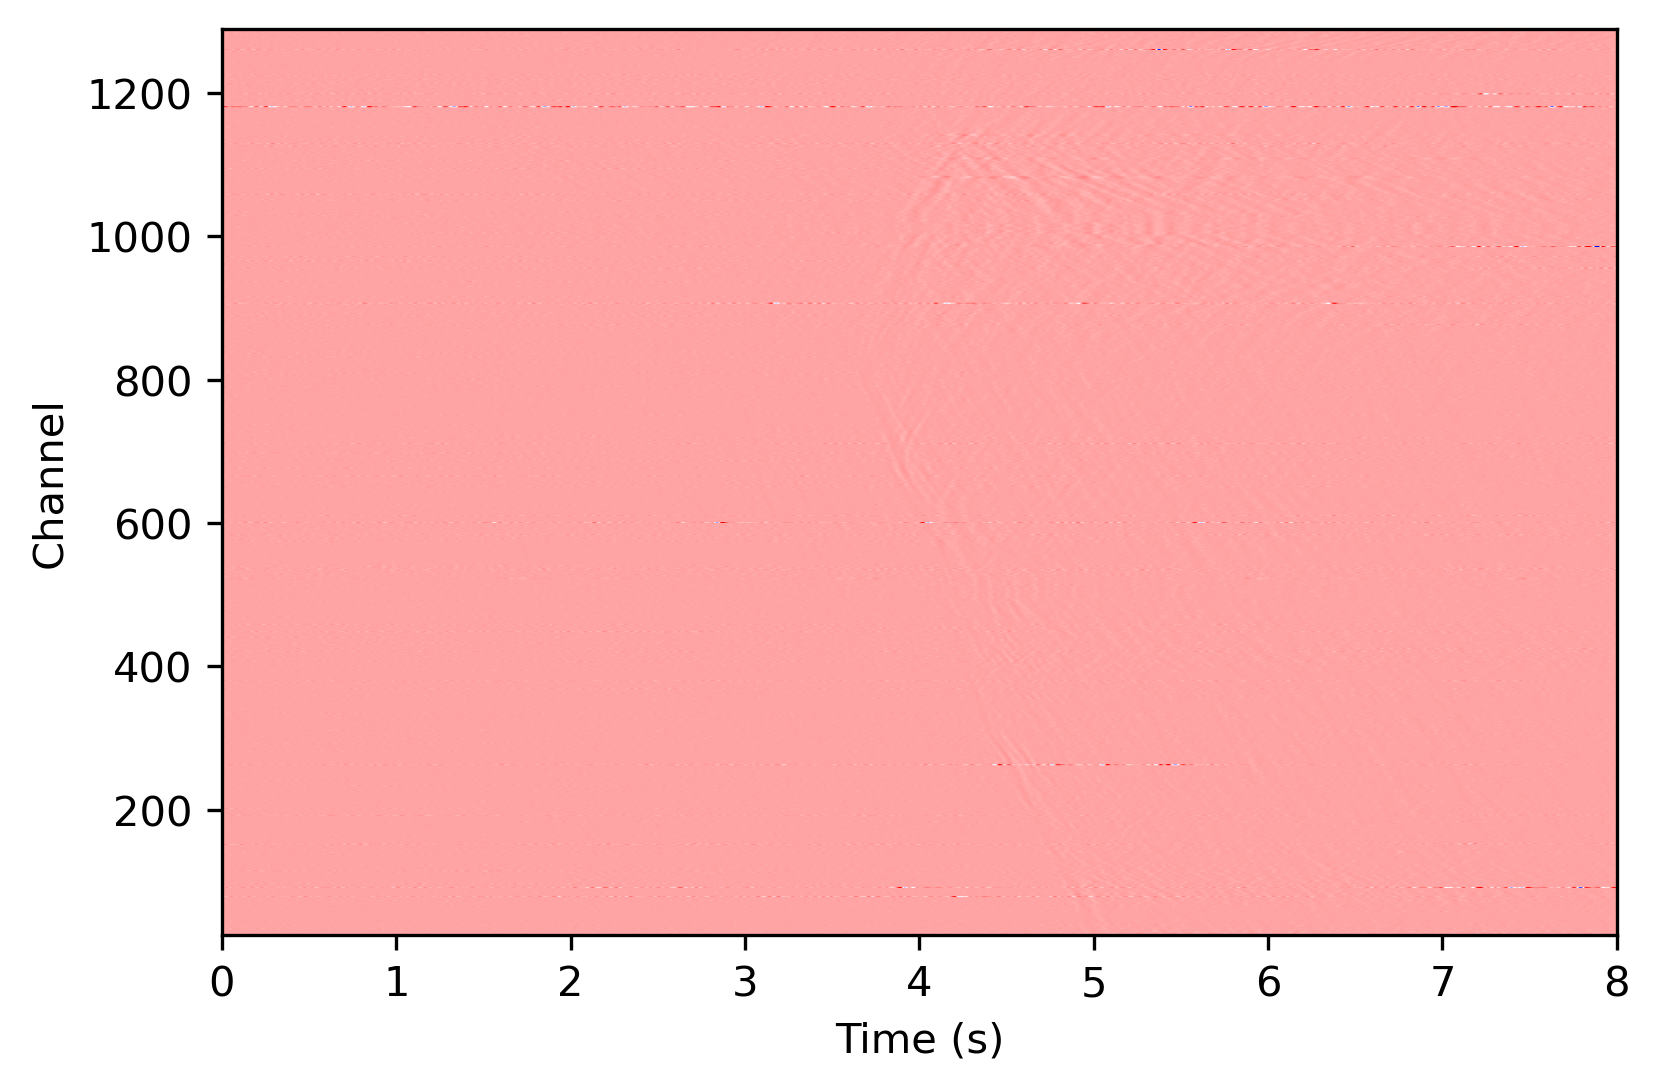

In [9]:
plot(data, t1-noise_window_len, t2, fs, startchannel[ev], endchannel[ev])

## clean data
identify bad traces in time and frequency domain, and replace them with average of neighbouring traces

In [10]:
data = clean_data(data, clean_amplitude, clean_threshold)

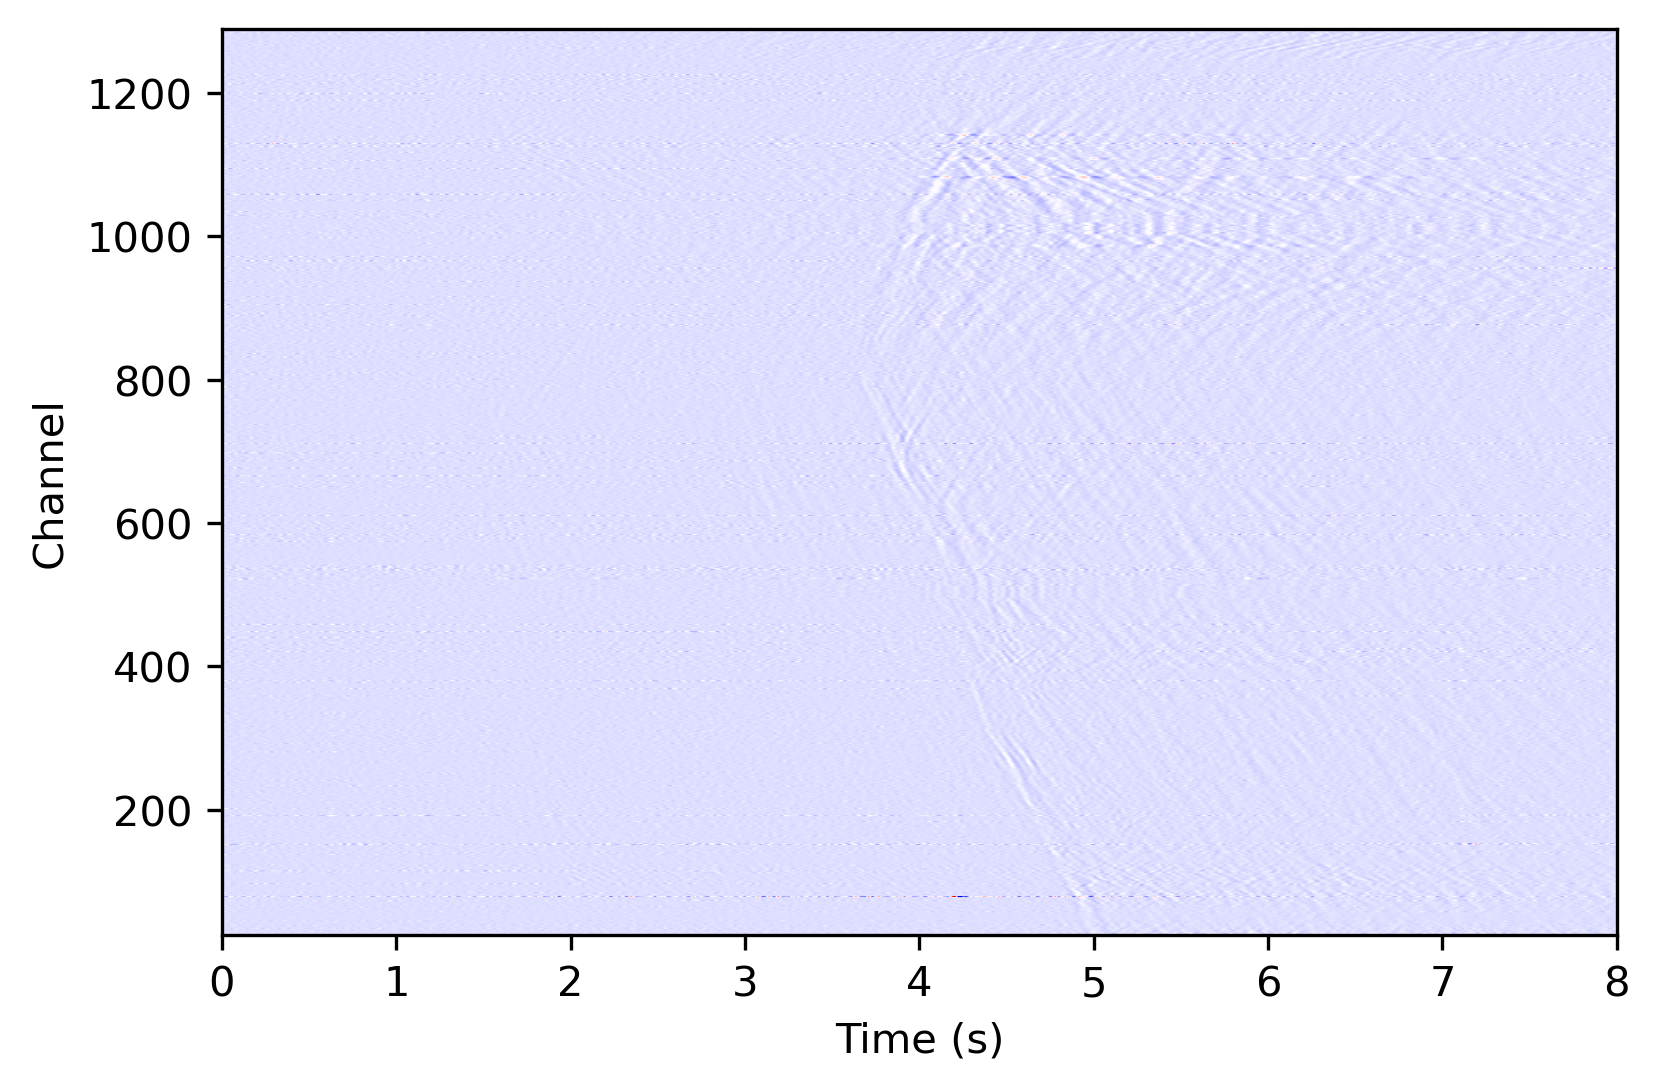

In [11]:
plot(data, t1-noise_window_len, t2, fs, startchannel[ev], endchannel[ev])

### calculate SNR

In [12]:
d = data.copy()

ps = np.zeros(len(d))
pn = np.zeros(len(d))

noise = d[:,0:int(noise_window_len*fs)].copy()
signal = d[:,int(noise_window_len*fs):].copy()

if starttime[ev] - endtime[ev-1] < 2:
    noise = default_noise.copy()

for i in range(len(d)):
    pn[i] = power(noise[i])
    ps[i] = power(signal[i])

pn[pn == 0] = 1
snr = ps/pn

### correlate channels with good SNR

In [13]:
idx_snr, jump = snr_channels(snr, snr_threshold1)

pick0, s0, id_good = correlate_channels(signal, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z)

if len(id_good) < good_channels:
    print("This event does not contain enough quality channels to continue.")

### interpolate in between channels with good SNR

In [14]:
pick, s = interpolate_channels(pick0, s0, idx_snr, id_good, len(signal), jump, interpolate_jump_fraction, jump_edge)

if np.count_nonzero(~np.isnan(pick)) == 0:
    print("This event does not contain enough quality picks to continue.")

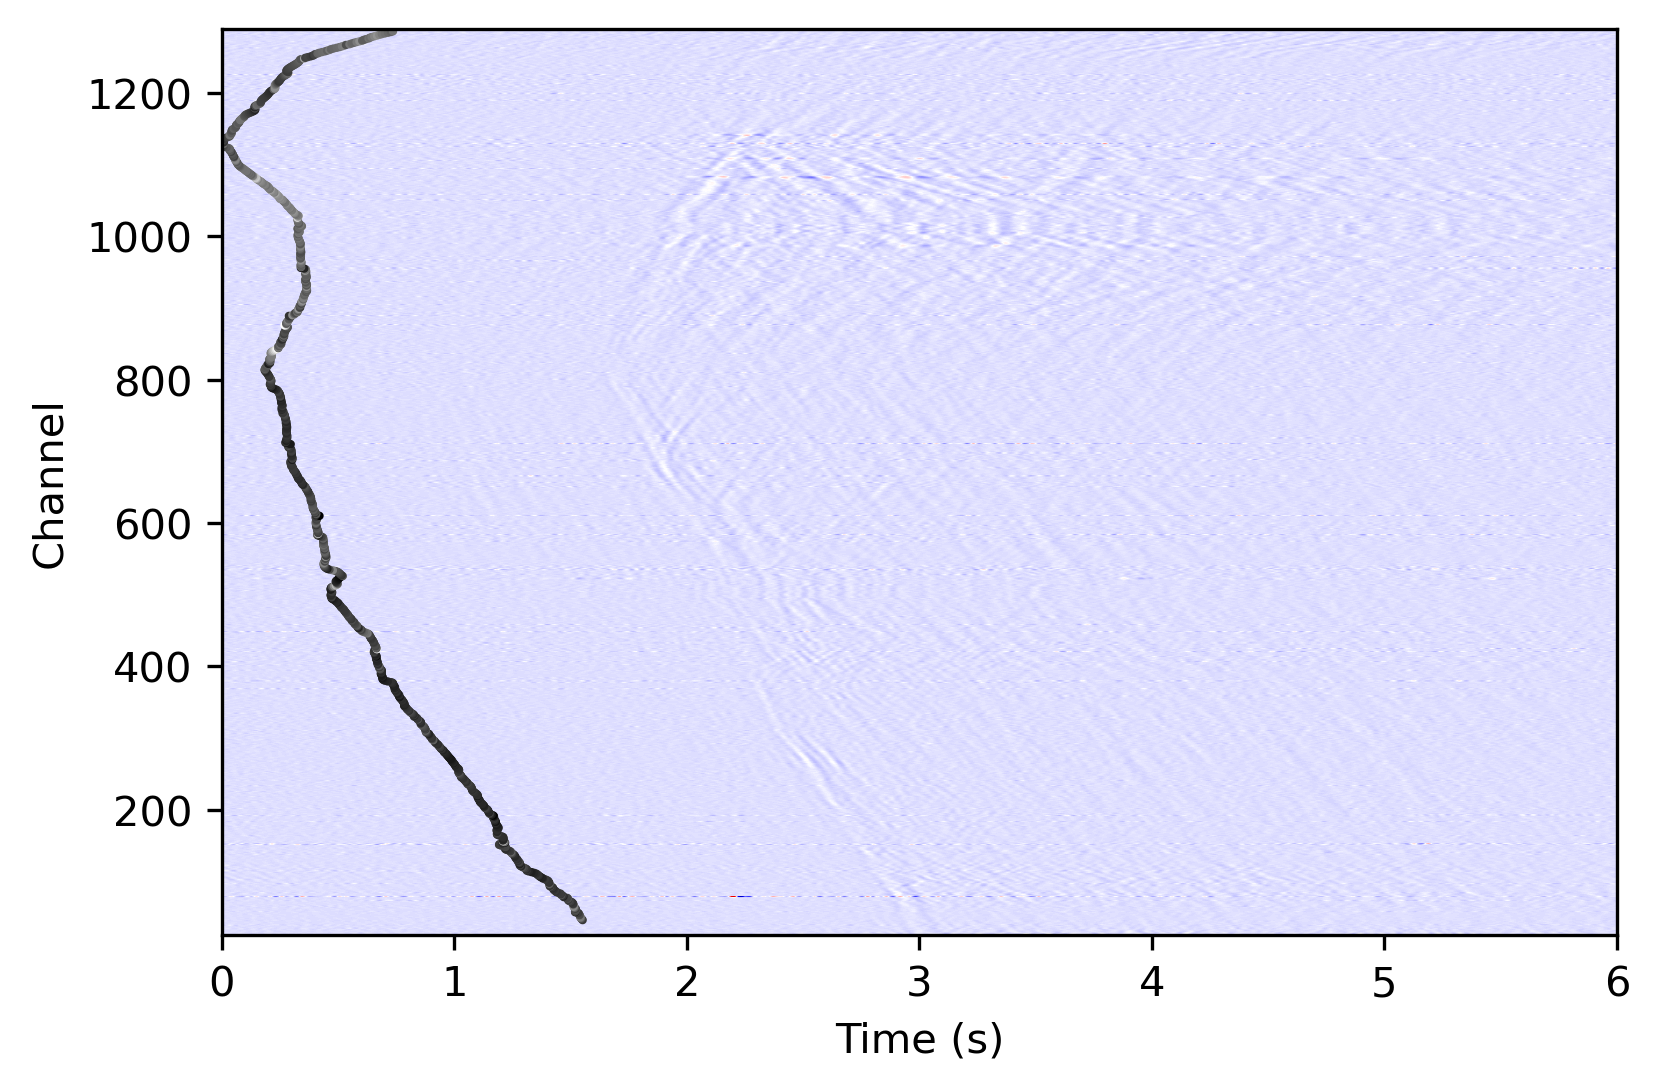

In [15]:
plot(signal, t1, t2, fs, startchannel[ev], endchannel[ev], picks=pick)

## shift picks with respect to data

In [16]:
picks = correlate_2d(signal, pick, shift_threshold_fraction1)
shift_fit = fit_channels(signal, picks, s)

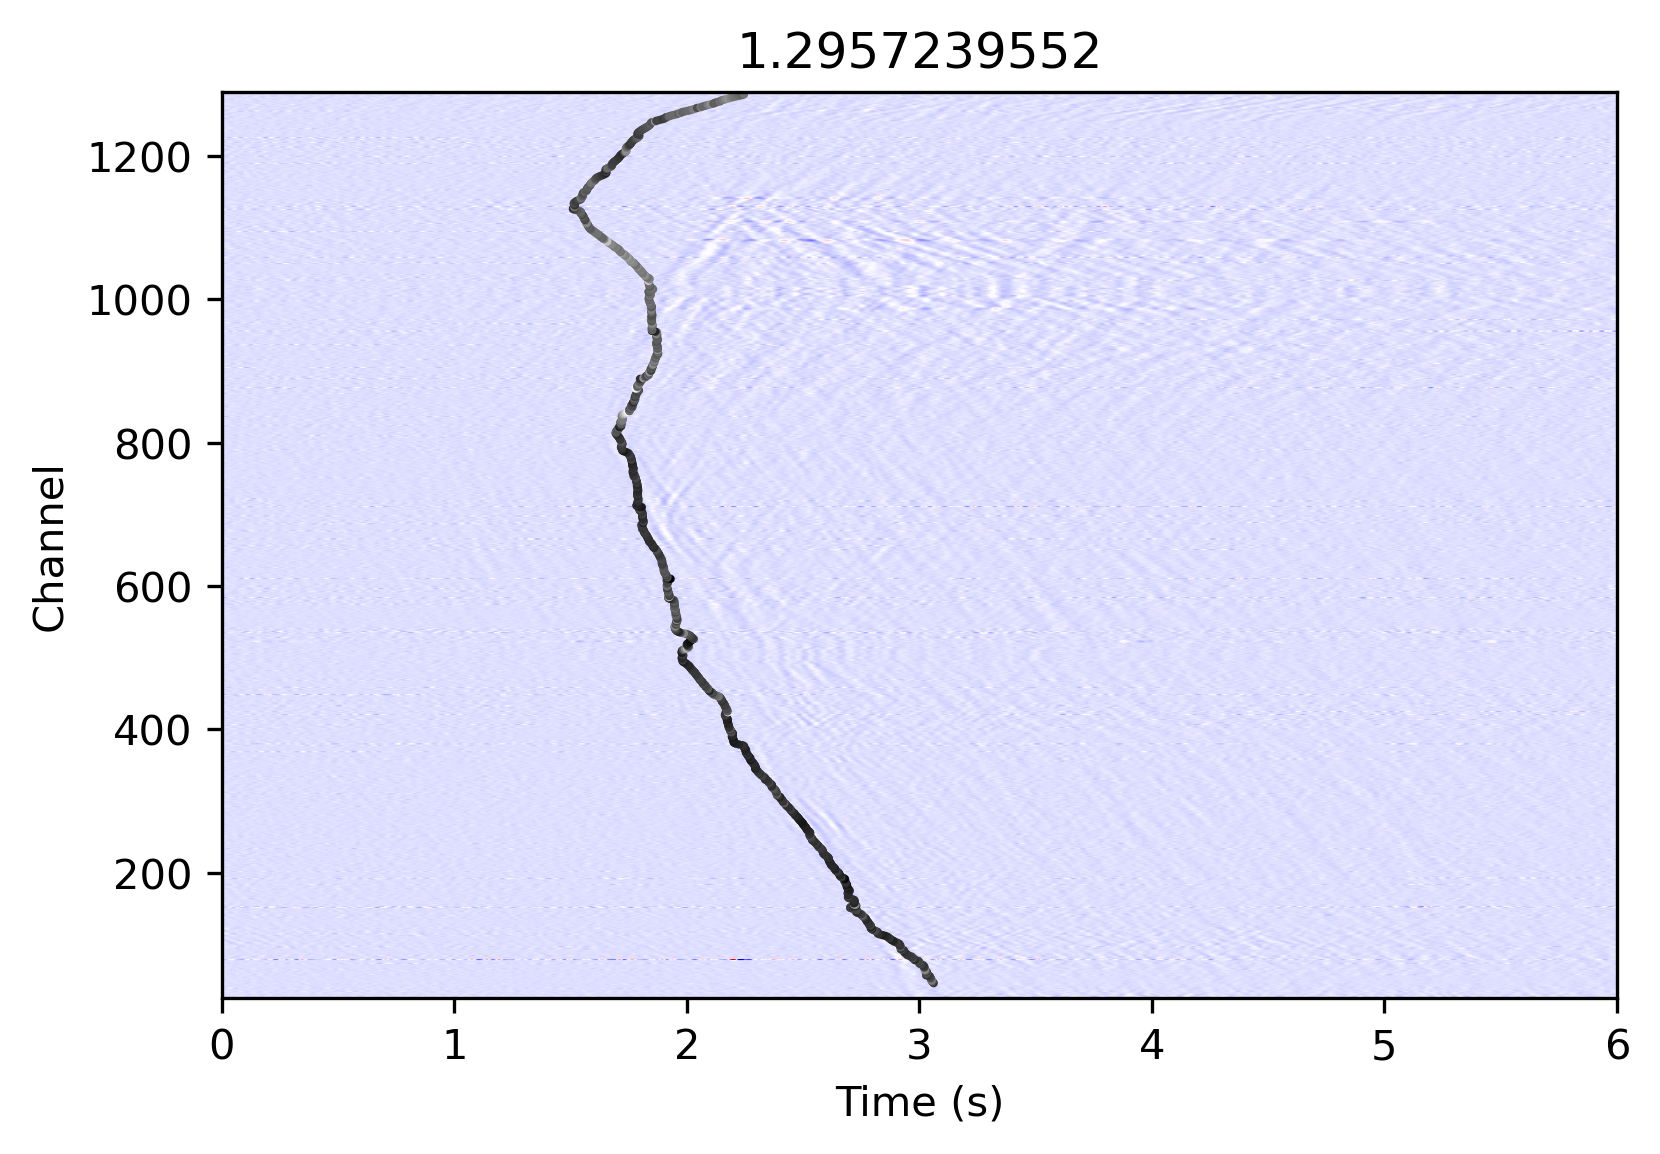

In [17]:
plot(signal, t1, t2, fs, startchannel[ev], endchannel[ev], picks=picks, shift_fit=shift_fit)

## iterations with smaller windows

In [18]:
iterated_picks = []
iterated_picks.append(picks.copy())

fit = []
fit.append(shift_fit)

uncertainty = []
uncertainty.append(s)

no_nan = ~np.isnan(iterated_picks[-1])

if np.count_nonzero(no_nan) < minimum_non_nan_picks:
    print("This event does not contain enough quality picks to continue.")

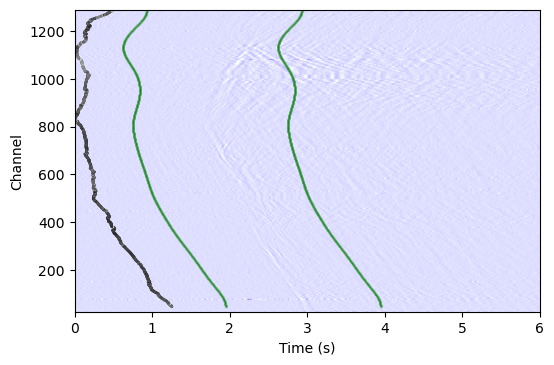

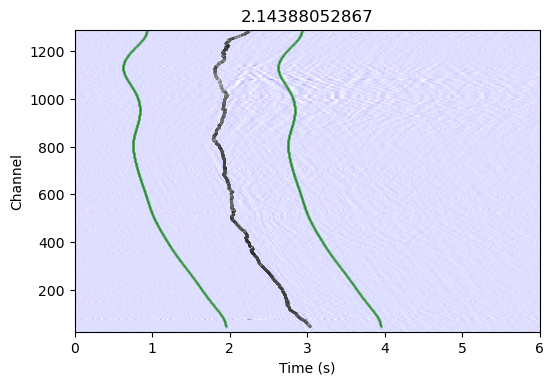

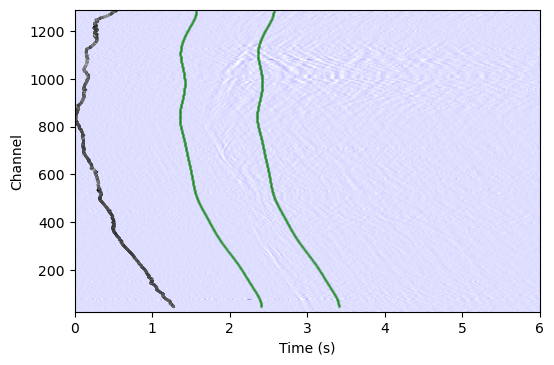

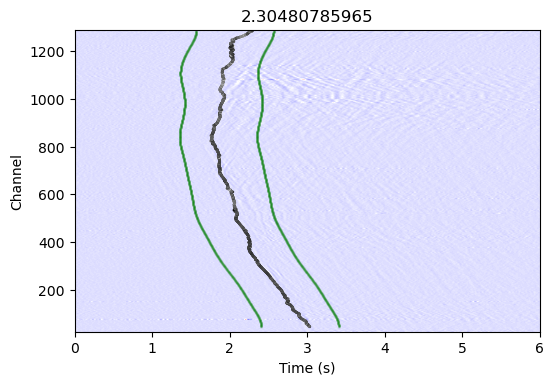

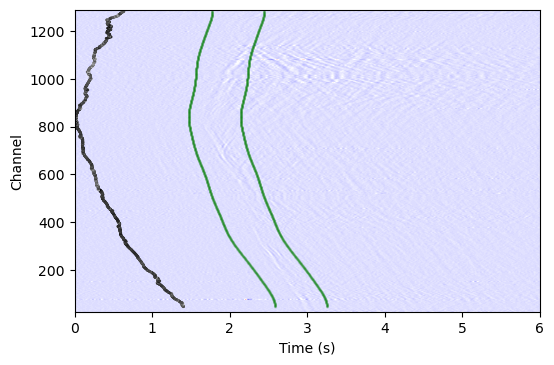

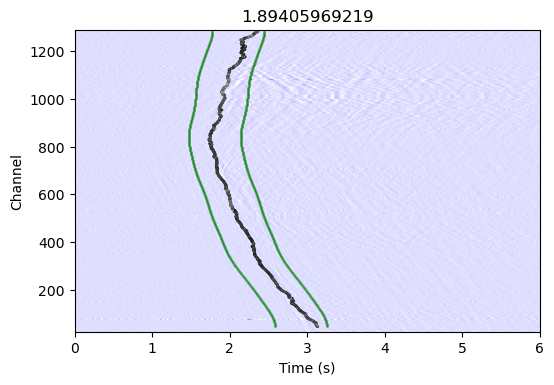

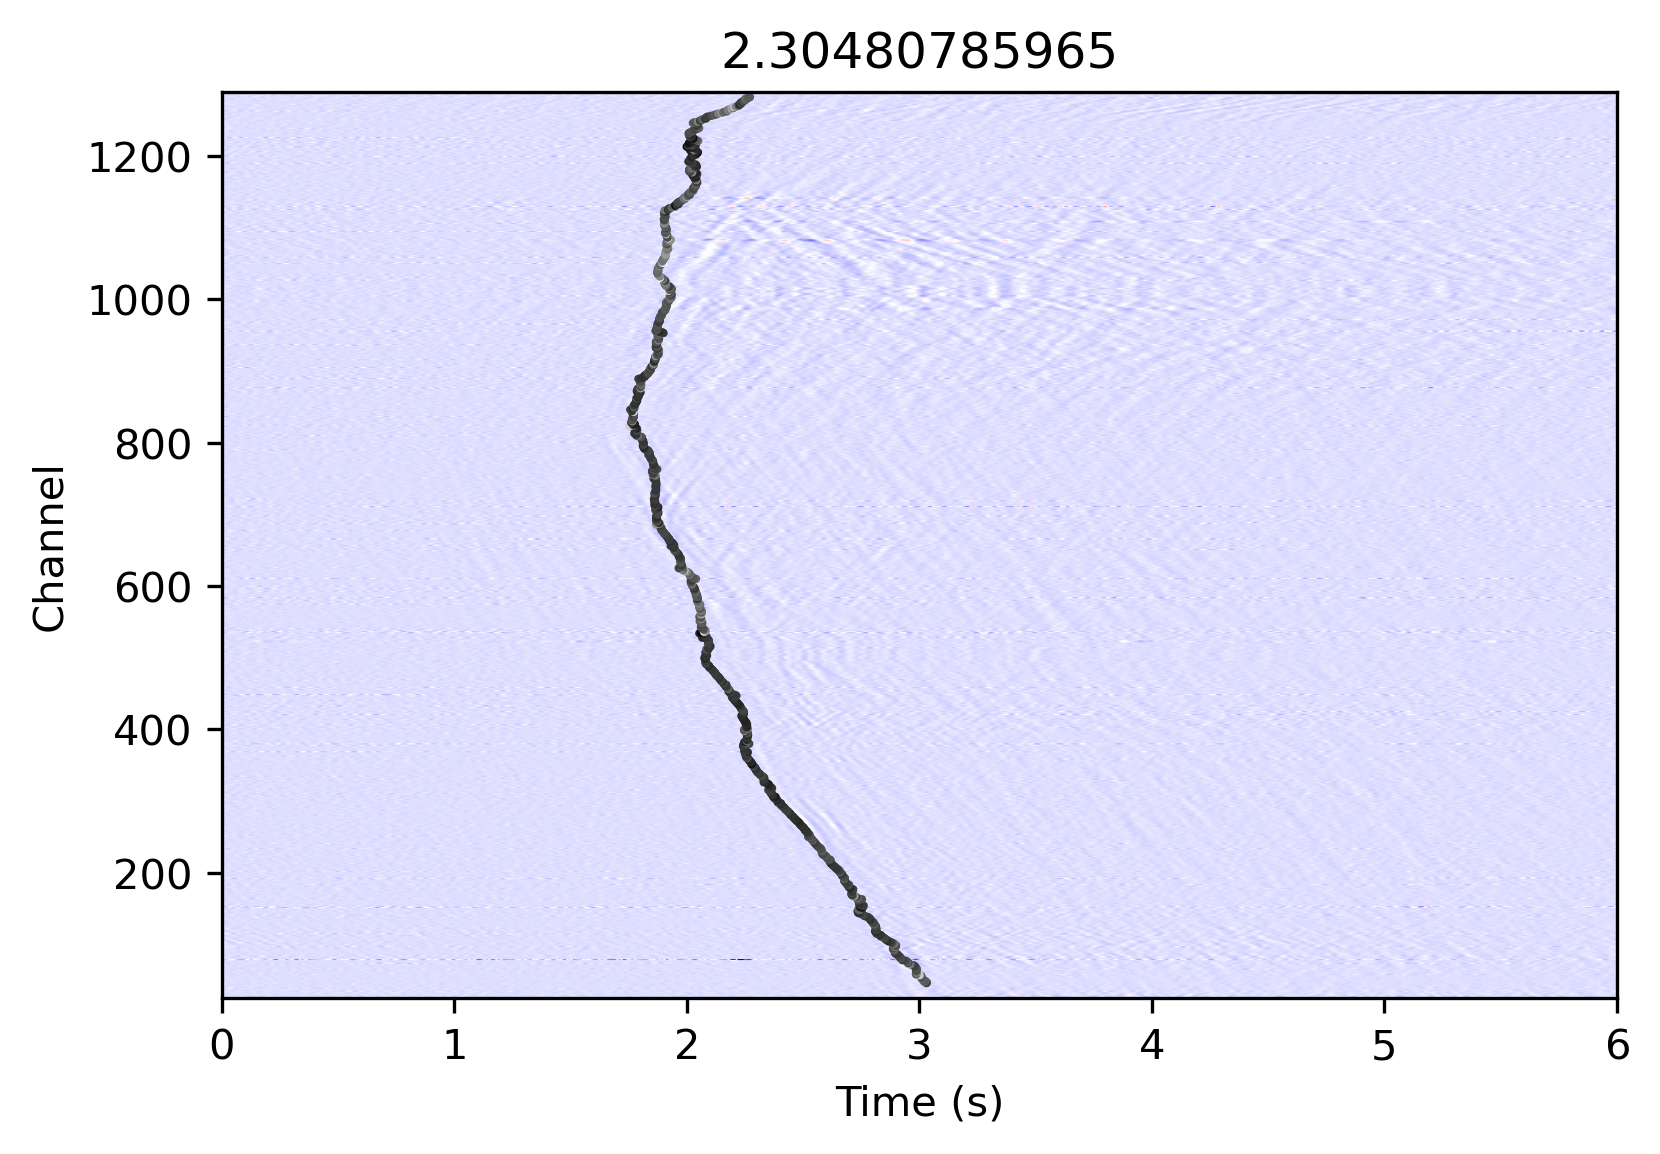

In [19]:
for it in range(iterations):
        
    ## define signal window
    
    window_len = int(signal.shape[1]/((it*decrease_window_product+decrease_window_sum)))
    while window_len%window_fraction != 0:
        window_len += 1
        
    
    ### define start and end windows around picks
    start_window, end_window = define_window(signal, iterated_picks[-1], window_len, window_fraction, window_smoothing)
    
    no_nan = ~np.isnan(iterated_picks[-1])
    
    ### create signal window
    signal_window = np.zeros(np.shape(signal))   
    for i in range(len(signal)):
        if no_nan[i]:
            signal_window[i, int(start_window[i]):int(end_window[i])] = signal[i, int(start_window[i]):int(end_window[i])]
   
    idx_snr, jump = snr_channels(snr, snr_threshold2)
    
    picks_cor, s0, id_good = correlate_channels(signal_window, idx_snr, interpolate_factor, minimum_velocity, startchannel, channel, fs, x, y, z, no_nan=no_nan)

    picks_interp, s = interpolate_channels(picks_cor, s0, idx_snr, id_good, len(signal), jump, interpolate_jump_fraction, jump_edge)
    
    picks_interp[~no_nan] = np.nan
    s[~no_nan] = np.nan
    if np.min(picks_interp[~np.isnan(picks_interp)]) > 0:
        picks_interp -= np.min(picks_interp[~np.isnan(picks_interp)])
    
    plot(signal, t1, t2, fs, startchannel[ev], endchannel[ev], picks=picks_interp, start_window=start_window, end_window=end_window, dpi=100)

    
    if shift_fit > 10:
        break
        
    
    ### fit picks with data
    picks_shifted = correlate_2d(signal_window, picks_interp, shift_threshold_fraction2)

    
    shift_fit = fit_channels(signal_window, picks_shifted, s)
    
    iterated_picks.append(picks_shifted)
    fit.append(shift_fit)
    uncertainty.append(s)
    

    plot(signal, t1, t2, fs, startchannel[ev], endchannel[ev], picks=iterated_picks[-1], shift_fit=shift_fit, start_window=start_window, end_window=end_window, dpi=100)


    
idx = np.argmax(fit)    

plot(signal, t1, t2, fs, startchannel[ev], endchannel[ev], picks=iterated_picks[idx], shift_fit=fit[idx], ev=ev, save=True)